# Building Taxi Fare Prediction using SageMaker 

<p>This demo notebook guides through the steps in creating an AWS Sagemaker predictions service</p>
<p>To start using Sagemaker go here: <a href="https://aws.amazon.com/sagemaker/">Sagemaker</a></p>

## Read the whole data from S3

In [1]:
import pandas as pd
import os
from s3fs.core import S3FileSystem
import random

import boto3
from botocore.client import Config
import json

In [2]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

arn:aws:iam::282784146513:role/service-role/AmazonSageMaker-ExecutionRole-20190604T113688


In [3]:
S3FileSystem.read_timeout = 3600

In [4]:
s3 = S3FileSystem(anon=False)
bucket = 'aws-worskhop-data/ZIPCHUNKS'
file_list = s3.ls(bucket)
subs = 'ZIPCHUNKS'
res = [i for i in file_list if subs in i] 

In [5]:
# we remove the folder ZIPCHUNKS if it exists (so later we can merge the files in loop)
if 'aws-worskhop-data/ZIPCHUNKS' in res: res.remove('aws-worskhop-data/ZIPCHUNKS')

In [6]:
res

['aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaa',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSab',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSac',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSad',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSae',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaf',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSag',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSah',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSai',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaj',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSak',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSal',
 'aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSam']

In [7]:
#res = res[0::5]

In [8]:
jj = 0

for filechunk in res:
        print (filechunk)
        if jj == 0:
            with s3.open('aws-worskhop-data/taxinyc_train.csv.zip', 'wb') as f:
                f.write(s3.cat(filechunk))
                jj = jj + 1        
                f.close()
        else:
            with s3.open('aws-worskhop-data/taxinyc_train.csv.zip', 'ab') as f:
                f.write(s3.cat(filechunk))
                jj = jj + 1
                f.close()

aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaa
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSab
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSac
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSad
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSae
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaf
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSag
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSah
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSai
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSaj
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSak
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSal
aws-worskhop-data/ZIPCHUNKS/ZIPCHUNKSam


In [9]:
bucket = 'aws-worskhop-data'
path = ''

filename = 'taxinyc_train.csv.zip'
s3_path = os.path.join('s3://', bucket, path, filename)

df_all = pd.read_csv(s3_path, header=0, skiprows=lambda i: i>0 and random.random() > 0.01)

In [10]:
df_all

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,6.50,22,7,2013,12,22,13,10,-0.998931,0.046235,-0.228958,-0.973436,2013-12-22 18:10:36 UTC,-73.972320,40.763702,-73.979470,40.775260,1
1,37.30,29,6,2011,10,29,19,26,-0.147809,0.989016,0.452879,-0.891572,2011-10-29 23:26:00 UTC,-74.001160,40.741596,-74.001160,40.741596,2
2,8.50,20,3,2011,7,20,4,37,0.773794,-0.633437,-0.544003,0.839083,2011-07-20 08:37:13 UTC,-73.981255,40.779236,-73.976280,40.757835,1
3,17.30,15,2,2012,5,15,21,49,0.457874,0.889017,-0.737698,0.675131,2012-05-16 01:49:00 UTC,-74.003240,40.749077,-73.961230,40.720060,2
4,5.50,27,7,2014,7,27,11,1,-0.710185,-0.704015,-0.112584,-0.993642,2014-07-27 15:01:00 UTC,-73.982620,40.727290,-73.983290,40.738644,5
5,16.10,28,7,2010,2,28,7,21,-0.091502,-0.995805,-0.013090,-0.999914,2010-02-28 12:21:00 UTC,-73.930695,40.755550,-73.989870,40.756510,1
6,19.50,16,5,2014,5,16,16,27,-0.800862,0.598849,0.995796,-0.091595,2014-05-16 20:27:09 UTC,-73.995950,40.723000,-73.955590,40.780464,1
7,4.10,29,6,2011,1,29,6,3,0.246153,-0.969231,0.803486,-0.595324,2011-01-29 11:03:00 UTC,-73.998250,40.735344,-73.997840,40.741207,1
8,6.50,13,7,2010,6,13,5,29,0.612217,-0.790690,0.093984,-0.995574,2010-06-13 09:29:00 UTC,-73.973015,40.678040,-73.987320,40.694714,1
9,6.90,31,7,2011,7,31,11,41,-0.821647,-0.569997,-0.137321,-0.990527,2011-07-31 15:41:00 UTC,-73.971290,40.794384,-73.949340,40.781773,2


## Start Exploring the data 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [12]:
# Sample the data - because it only take a 100K records to feel the data
df_all = df_all.sample(int(1e5))

In [13]:
df_small = df_all.sample(int(1e2))
df_small

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
289047,7.00,23,2,2012,10,23,12,18,-0.902585,-0.430511,-0.926716,0.375762,2012-10-23 16:18:00 UTC,-73.978290,40.757755,-73.989130,40.740700,1
102325,10.50,15,2,2009,9,15,9,25,-0.364132,-0.931347,-0.961704,0.274089,2009-09-15 13:25:25 UTC,-73.961380,40.774470,-73.983850,40.743600,1
292949,6.50,13,3,2011,4,13,9,33,-0.395212,-0.918590,-0.380888,0.924621,2011-04-13 13:33:07 UTC,-73.973360,40.763390,-73.985460,40.747208,1
520308,9.70,16,1,2012,1,16,10,13,-0.746977,-0.664850,-0.851111,-0.524985,2012-01-16 15:13:19 UTC,-73.968445,40.759247,-73.927414,40.756810,1
512042,10.50,19,5,2010,2,19,3,35,0.777237,-0.629207,0.938830,0.344382,2010-02-19 08:35:58 UTC,-74.013954,40.716747,-73.990280,40.742670,1
503061,6.10,16,7,2011,10,16,18,53,-0.284782,0.958592,-0.396356,-0.918097,2011-10-16 22:53:49 UTC,-73.967700,40.760300,-73.953400,40.767300,0
400577,10.00,28,7,2013,4,28,9,1,-0.263031,-0.964787,-0.038014,-0.999277,2013-04-28 13:01:00 UTC,-73.952090,40.777280,-73.977100,40.763184,1
360141,5.30,30,6,2010,10,30,17,3,-0.696330,0.717721,0.530201,-0.847872,2010-10-30 21:03:28 UTC,-73.968430,40.754986,-73.974464,40.743500,1
238719,11.00,30,4,2015,4,30,21,5,0.280108,0.959968,0.806469,0.591276,2015-05-01 01:05:04 UTC,-73.987854,40.718315,-73.944620,40.715954,1
401803,8.50,15,2,2011,2,15,15,56,-0.716403,0.697686,-0.847729,0.530430,2011-02-15 20:56:58 UTC,-73.986440,40.767140,-73.985115,40.746185,1


In [14]:
df_all.describe()

,fare_amount,day,dayofweek,year,month,dayofmonth,hour,minute,sin_day,cos_day,sin_week,cos_week,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,11.363466,15.75123,3.972010,2011.743830,6.273750,15.75123,11.829470,29.53661,-0.202735,-0.039568,0.043770,0.032928,-72.521931,39.927625,-72.525638,39.932595,1.68192
std,9.910048,8.67760,1.902667,1.856669,3.431881,8.67760,5.846821,17.32192,0.652754,0.728872,0.711854,0.700196,10.642595,6.196503,10.587562,6.204464,1.30640
min,-3.500000,1.00000,1.000000,2008.000000,1.000000,1.00000,0.000000,0.00000,-1.000000,-1.000000,-1.000000,-1.000000,-736.350000,-74.009190,-736.350000,-74.016335,0.00000
25%,6.000000,8.00000,2.000000,2010.000000,3.000000,8.00000,7.000000,14.00000,-0.816568,-0.771625,-0.712310,-0.663384,-73.992130,40.735050,-73.991394,40.734240,1.00000
50%,8.500000,16.00000,4.000000,2012.000000,6.000000,16.00000,12.000000,30.00000,-0.337917,-0.099609,0.030139,0.083875,-73.981926,40.752674,-73.980110,40.753174,1.00000
75%,12.500000,23.00000,6.000000,2013.000000,9.000000,23.00000,17.000000,45.00000,0.366501,0.717164,0.719966,0.733899,-73.967383,40.767082,-73.963800,40.767967,2.00000
max,479.350000,31.00000,7.000000,2015.000000,12.000000,31.00000,23.000000,59.00000,1.000000,1.000000,1.000000,1.000000,40.816296,424.083340,40.815876,456.183320,6.00000


### Date-Time Features 

In [15]:
df_all['ts'] = df_all['pickup_datetime'].apply(pd.Timestamp)
df_all['weekday'] = df_all['ts'].dt.weekday
df_all['day'] = df_all['ts'].dt.day
df_all['month'] = df_all['ts'].dt.month
df_all['year'] = df_all['ts'].dt.year
df_all['hour'] = df_all['ts'].dt.hour

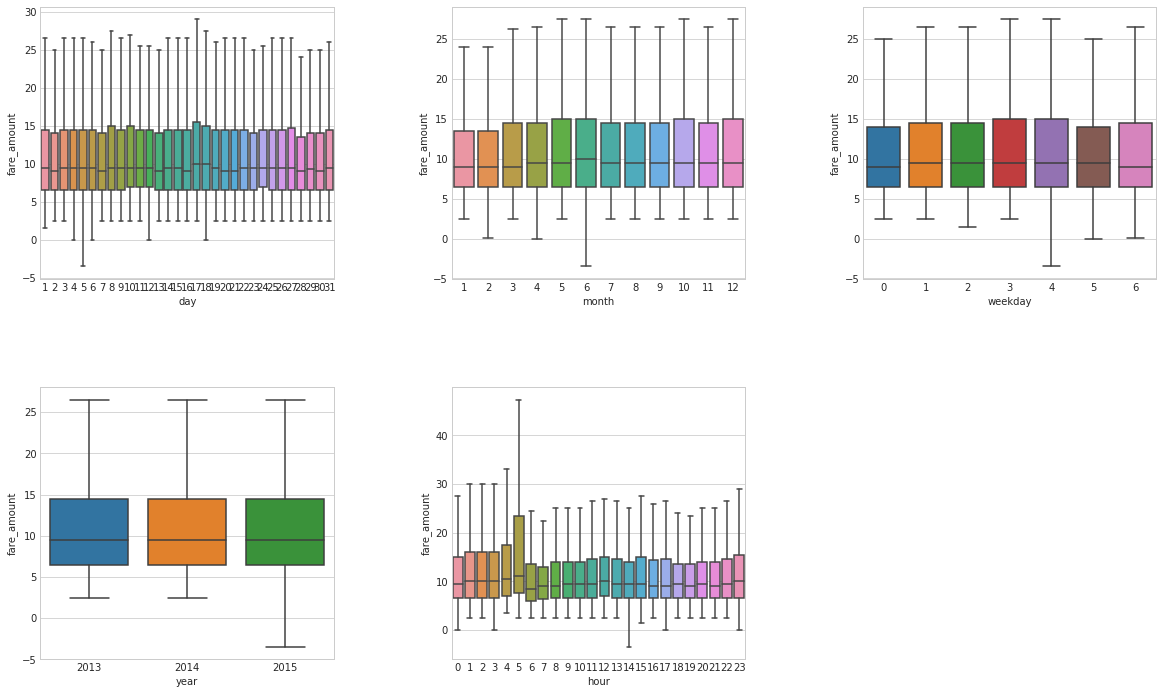

In [16]:
time_features = ['day', 'month', 'weekday', 'year', 'hour']

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(x=time_features[i], y="fare_amount", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

### Geographic 

https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [17]:
nyc_box = (-74.1, -73.7, 40.6, 40.9)

In [18]:
def filter_coordinates(df, box):
    return (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.pickup_latitude >= box[2]) & (df.pickup_latitude <=box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3])

In [19]:
def plot_hires(df, box, figsize=(12, 12), ax=None, c=sns.color_palette("husl", 2)):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = filter_coordinates(df, box)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.1, lw=0.1, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.1, lw=0.1, alpha=0.5)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


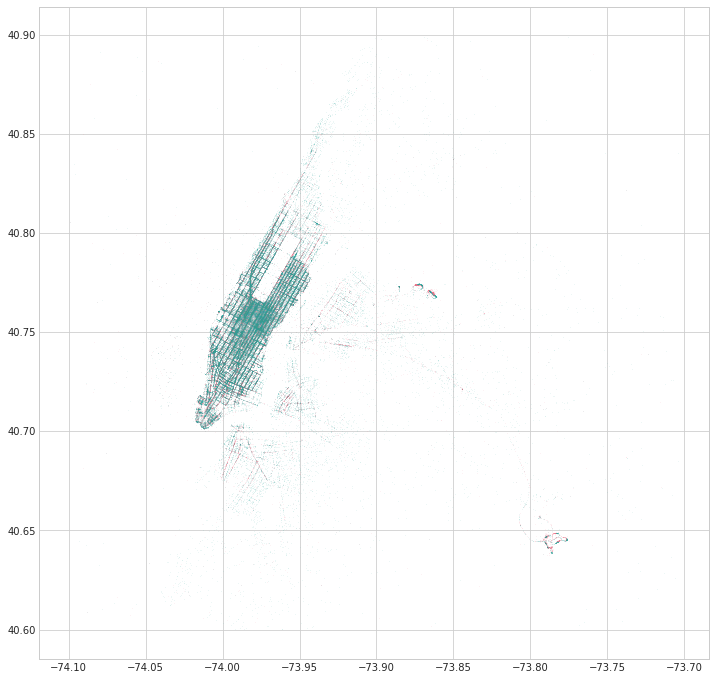

In [20]:
plot_hires(df_all, nyc_box)

<p>In the scatter plot above, the two major NYC airports are easily observed, indicating that it may be informative to "tell" our algorithm whether the ride starts or ends in an airport.</p>
<p>To do so I use the airports.csv, available <a href="http://ourairports.com/data/">here</a> in the following way:</p>
<ul>
<li>from this file I extract the location of 3 of the listed NYC airports</li>
<li>I than calculate the distance of dropoff and pickup points from every record to each airport, Assuming it will provide additional information to our model.</li>
</ul>
<p>Further details are in the feature extraction below</p>

## Ride distance 

In [21]:
df_all['air_distance'] = (df_all.pickup_longitude - df_all.dropoff_longitude)**2 +\
                     (df_all.pickup_latitude - df_all.dropoff_latitude)**2
df_all['air_distance'] = np.sqrt(df_all['air_distance'])

In [22]:
df_all['price_per_distance'] = df_all['fare_amount'] / df_all['air_distance']

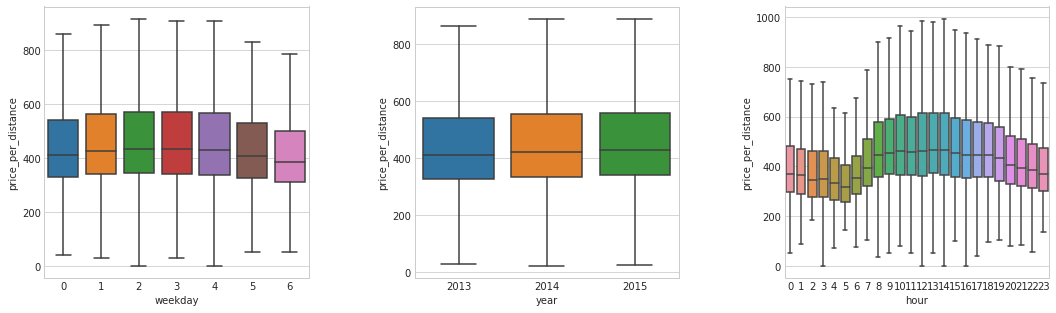

In [23]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="price_per_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

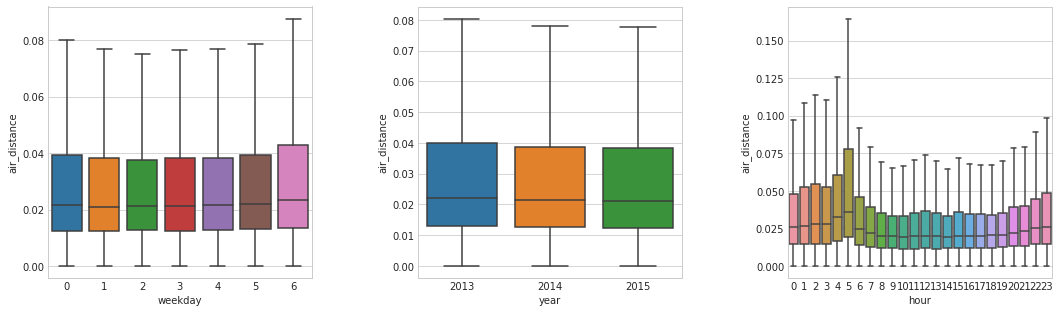

In [24]:
time_features = ['weekday', 'year', 'hour']
fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(x=time_features[i], y="air_distance", data=df_all[df_all['year'] >= 2013], showfliers=False)

plt.show()

## Split train test 

<p>If you managed to create the dataset using Athena, you have two options on how to create train and validation sets files.&nbsp;</p>
<ol>
<li>Create a seperate query, using a WHERE on the year clause to split the train and validation by time (e.g. year, month)</li>
<li>Create a single query, partition the results by time, and use aws-cli to mv the directories to different train/validation directotires</li>
</ol>

## Train model 

In [25]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [26]:
bucket = 'aws-worskhop-data'

path_train = 'taxinyc-query-results/train/78a6a6df-267a-4783-bef4-fd6eb4f082fa.csv'
path_validate = 'taxinyc-query-results/validate/60c4073e-00bc-4e80-a9aa-d93e53687a28.csv' 

s3_path_2014 = os.path.join('s3://', bucket, path_train)
s3_path_2015 = os.path.join('s3://', bucket, path_validate)

In [27]:
df_2014 = pd.read_csv(s3_path_2014, header=0, skiprows=lambda i: i>0 and random.random() > 0.1)

#n = 10  # every 100th line = 1% of the lines
#df_2014 = pd.read_csv(s3_path_2014, header=0, skiprows=lambda i: i % n != 0)

df_2014
df_2014.to_csv('train_small_2014.csv', header=False, index=False)
df_2014_final = pd.read_csv('./train_small_2014.csv')
df_2014_final

,6.0,30,4,2014,10,30.1,7,8,0.2249510543452318,-0.9743700647849196,0.4044576131442751,0.9145567446417068,-73.97471999999999,40.754658,-73.9806,40.74557,1
0,8.5,20,4,2014,11,20,18,44,-0.066709,0.997772,0.775850,0.630918,-73.984604,40.759907,-73.988730,40.745705,1
1,14.5,18,5,2014,4,18,19,10,-0.216440,0.976296,0.981389,-0.192033,0.000000,0.000000,0.000000,0.000000,1
2,8.0,25,7,2014,5,25,3,48,0.891007,-0.453990,0.156434,-0.987688,-73.952380,40.766254,-73.971790,40.744150,1
3,20.5,19,3,2014,3,19,13,50,-0.999048,-0.043619,-0.228594,0.973522,-74.004170,40.721920,-73.974460,40.761066,5
4,7.0,24,4,2014,4,24,17,43,-0.562805,0.826590,0.725803,0.687902,-73.994064,40.751360,-73.982980,40.759308,5
5,16.0,9,3,2014,4,9,5,12,0.669077,-0.743193,-0.525675,0.850686,-73.975710,40.752070,-74.002810,40.706500,1
6,7.5,16,4,2014,1,16,9,49,-0.672582,-0.740023,0.526249,0.850330,-73.988110,40.719894,-73.994410,40.729237,1
7,32.0,22,1,2014,9,22,7,58,0.008727,-0.999962,-0.781054,-0.624464,-73.863880,40.769627,-73.998764,40.720425,5
8,23.0,7,3,2014,5,7,16,36,-0.777146,0.629320,-0.126817,0.991926,-73.995735,40.723250,-73.973320,40.795288,5
9,10.5,24,7,2014,8,24,14,38,-0.986286,0.165048,-0.245549,-0.969384,-73.979294,40.766502,-73.984880,40.742950,3


In [28]:
df_2015 = pd.read_csv(s3_path_2015, header=0, skiprows=lambda i: i>0 and random.random() > 0.1)

#n = 10  # every 100th line = 1% of the lines
#df_2015 = pd.read_csv(s3_path_2015, header=0, skiprows=lambda i: i % n != 0)

df_2015
df_2015.to_csv('validate_small_2015.csv', header=False, index=False)
df_2015_final = pd.read_csv('./validate_small_2015.csv')
df_2015_final

,13.0,7,2,2015,4,7.1,2.1,17,0.9971413439166044,-0.07555885290413136,-0.9999416328309024,0.010804208970073406,-73.97719000000001,40.776978,-73.93966,40.805316999999995,1
0,6.50,15,7,2015,3,15,1,25,0.988962,0.148169,0.243182,-0.969981,-73.957200,40.767582,-73.981865,40.773598,2
1,17.00,23,4,2015,4,23,14,23,-0.994873,0.101129,0.634739,0.772727,-73.972870,40.753350,-73.962880,40.794100,5
2,7.50,7,6,2015,3,7,12,17,-0.982801,-0.184666,0.644012,-0.765015,-74.001650,40.735497,-74.005010,40.716410,1
3,4.50,13,1,2015,4,13,21,1,0.263312,0.964711,-0.982690,-0.185258,-73.993730,40.741863,-73.994705,40.742110,1
4,6.00,21,4,2015,5,21,23,37,0.813143,0.582064,0.858965,0.512034,-73.997470,40.741660,-73.998886,40.754887,1
5,9.50,27,6,2015,6,27,15,18,-0.941764,0.336274,0.584452,-0.811428,-73.986420,40.761320,-73.994580,40.750420,1
6,10.50,2,6,2015,5,2,19,49,-0.044055,0.999029,0.439547,-0.898219,-74.008514,40.719727,-73.987915,40.735287,1
7,7.50,17,2,2015,3,17,16,43,-0.756805,0.653641,-0.852227,0.523172,-73.979890,40.760540,-73.994090,40.763970,2
8,27.00,8,4,2015,1,8,21,19,0.570057,0.821605,0.832858,0.553487,-73.972910,40.753143,-73.937850,40.851960,1
9,5.00,21,2,2015,4,21,18,36,-0.356126,0.934438,-0.813191,0.581996,-73.988720,40.758762,-73.982150,40.763702,1


In [29]:
!aws s3 cp train_small_2014.csv s3://aws-worskhop-data/taxinyc-query-results/train2/train_small_2014.csv

upload: ./train_small_2014.csv to s3://aws-worskhop-data/taxinyc-query-results/train2/train_small_2014.csv


In [30]:
!aws s3 cp validate_small_2015.csv s3://aws-worskhop-data/taxinyc-query-results/validate2/validate_small_2015.csv

upload: ./validate_small_2015.csv to s3://aws-worskhop-data/taxinyc-query-results/validate2/validate_small_2015.csv


In [31]:
path_train = os.path.join('taxinyc-query-results','train2')
path_val = os.path.join('taxinyc-query-results','validate2')
bucket = 'aws-worskhop-data'

In [32]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [33]:
's3://{}/{}'.format(bucket, path_train)

's3://aws-worskhop-data/taxinyc-query-results/train2'

In [34]:
s3_input_trains3_inpu  = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_train),
                                            content_type='csv',
                                            distribution='ShardedByS3Key')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_val),
                                         content_type='csv', 
                                         distribution='ShardedByS3Key')

In [35]:
sess = sagemaker.Session()
role = get_execution_role()

In [36]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

In [37]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
                                    sagemaker_session=sess)

In [38]:
's3://{}/{}/output'.format(bucket,training_job_path)

's3://aws-worskhop-data/training_jobs/2020-06-01-18-27-33/output'

In [39]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)


In [40]:
xgb.fit({'train': s3_input_trains3_inpu, 'validation': s3_input_validation})

2020-06-01 18:27:33 Starting - Starting the training job...
2020-06-01 18:27:35 Starting - Launching requested ML instances.........
2020-06-01 18:29:08 Starting - Preparing the instances for training...
2020-06-01 18:30:02 Downloading - Downloading input data...
2020-06-01 18:30:34 Training - Downloading the training image...
2020-06-01 18:30:53 Training - Training image download completed. Training in progress.
Arguments: train
[2020-06-01:18:30:54:INFO] Running standalone xgboost training.
[2020-06-01:18:30:54:INFO] File size need to be processed in the node: 174.41mb. Available memory size in the node: 8445.2mb
[2020-06-01:18:30:54:INFO] Determined delimiter of CSV input is ','
[18:30:54] S3DistributionType set as ShardedByS3Key
[18:30:54] 825930x16 matrix with 13214880 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-01:18:30:54:INFO] Determined delimiter of CSV input is ','
[18:30:54] S3DistributionType set as ShardedByS3Key
[18:30:54] 3

[18:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[41]#011train-rmse:4.78824#011validation-rmse:5.5629
[18:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[42]#011train-rmse:4.77603#011validation-rmse:5.55041
[18:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[43]#011train-rmse:4.77422#011validation-rmse:5.55015
[18:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[44]#011train-rmse:4.76844#011validation-rmse:5.54622
[18:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[45]#011train-rmse:4.76154#011validation-rmse:5.54012
[18:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[46]#011train-rmse:4.7588#011validation-rmse:5.5394
[18:3

[18:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[91]#011train-rmse:4.62577#011validation-rmse:5.43464
[18:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[92]#011train-rmse:4.62522#011validation-rmse:5.43451
[18:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[93]#011train-rmse:4.62492#011validation-rmse:5.43403
[18:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[94]#011train-rmse:4.62431#011validation-rmse:5.43407
[18:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[95]#011train-rmse:4.62307#011validation-rmse:5.43328
[18:32:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[96]#011train-rmse:4.62194#011validation-rmse:5.43257
[18:

[18:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[143]#011train-rmse:4.56872#011validation-rmse:5.39771
[18:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[144]#011train-rmse:4.56856#011validation-rmse:5.39794
[18:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[145]#011train-rmse:4.56841#011validation-rmse:5.39773
[18:33:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[146]#011train-rmse:4.56771#011validation-rmse:5.39781
[18:33:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[147]#011train-rmse:4.56722#011validation-rmse:5.39829
[18:33:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[148]#011train-rmse:4.56654#011validation-rmse:5.3974

[194]#011train-rmse:4.52221#011validation-rmse:5.37322
[18:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[195]#011train-rmse:4.52146#011validation-rmse:5.37319
[18:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[196]#011train-rmse:4.52083#011validation-rmse:5.37269
[18:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[197]#011train-rmse:4.52038#011validation-rmse:5.37235
[18:34:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[198]#011train-rmse:4.5149#011validation-rmse:5.36784
[18:34:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[199]#011train-rmse:4.51443#011validation-rmse:5.3676
[18:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9

[18:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[246]#011train-rmse:4.48512#011validation-rmse:5.35349
[18:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[247]#011train-rmse:4.48491#011validation-rmse:5.35323
[18:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[248]#011train-rmse:4.4845#011validation-rmse:5.35275
[18:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[249]#011train-rmse:4.48423#011validation-rmse:5.35247
[18:35:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[250]#011train-rmse:4.48377#011validation-rmse:5.35272
[18:35:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=9
[251]#011train-rmse:4.4837#011validation-rmse:5.35247


[18:35:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[299]#011train-rmse:4.45314#011validation-rmse:5.34039
[18:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[300]#011train-rmse:4.45218#011validation-rmse:5.34027
[18:35:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[301]#011train-rmse:4.45152#011validation-rmse:5.33987
[18:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[302]#011train-rmse:4.45147#011validation-rmse:5.33949
[18:35:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[303]#011train-rmse:4.4509#011validation-rmse:5.33938
[18:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[304]#011train-rmse:4.45066#011validation-rmse:5.34009

[355]#011train-rmse:4.42305#011validation-rmse:5.32753
[18:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[356]#011train-rmse:4.42268#011validation-rmse:5.32767
[18:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[357]#011train-rmse:4.42244#011validation-rmse:5.32793
[18:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[358]#011train-rmse:4.42206#011validation-rmse:5.32785
[18:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[359]#011train-rmse:4.42183#011validation-rmse:5.32747
[18:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=9
[360]#011train-rmse:4.42175#011validation-rmse:5.32691
[18:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=

[18:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[407]#011train-rmse:4.39464#011validation-rmse:5.31706
[18:37:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[408]#011train-rmse:4.39438#011validation-rmse:5.31689
[18:37:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[409]#011train-rmse:4.39392#011validation-rmse:5.31651
[18:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[410]#011train-rmse:4.39378#011validation-rmse:5.31649
[18:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[411]#011train-rmse:4.39279#011validation-rmse:5.31708
[18:37:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[412]#011train-rmse:4.39243#011validation-rmse:5.3170


2020-06-01 18:38:39 Uploading - Uploading generated training model[18:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[459]#011train-rmse:4.3735#011validation-rmse:5.31293
[18:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[460]#011train-rmse:4.37318#011validation-rmse:5.31302
[18:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[461]#011train-rmse:4.37264#011validation-rmse:5.31337
[18:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[462]#011train-rmse:4.37236#011validation-rmse:5.31381
[18:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[463]#011train-rmse:4.37225#011validation-rmse:5.31376
[18:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes,

## Deploy the model 

In [41]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------------------------------------------------------------------!

## Evaluate results 

Parts taken from here:<br>
https://aws.amazon.com/blogs/machine-learning/simplify-machine-learning-with-xgboost-and-amazon-sagemaker/

In [42]:
from sagemaker.predictor import csv_serializer

In [43]:
df_test = pd.read_csv('./validate_small_2015.csv', header=None)

In [44]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(df_test.as_matrix()[:, 1:])
predictions

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


array([13.18175602,  8.0798111 , 14.93207455, ...,  7.7606535 ,
       14.53370762,  5.88540125])

In [45]:
df_val = pd.DataFrame()
df_val['prediction'] = predictions
df_val['target'] = df_test[0]

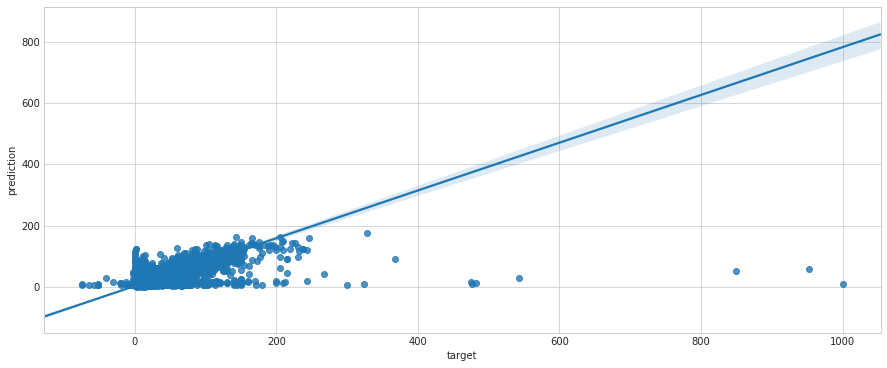

In [46]:
plt.figure(figsize=(15,6))
sns.regplot(x=df_val["target"], y=df_val["prediction"])
plt.show()

In [47]:
df_val['err'] = (df_val["target"] - df_val["prediction"])

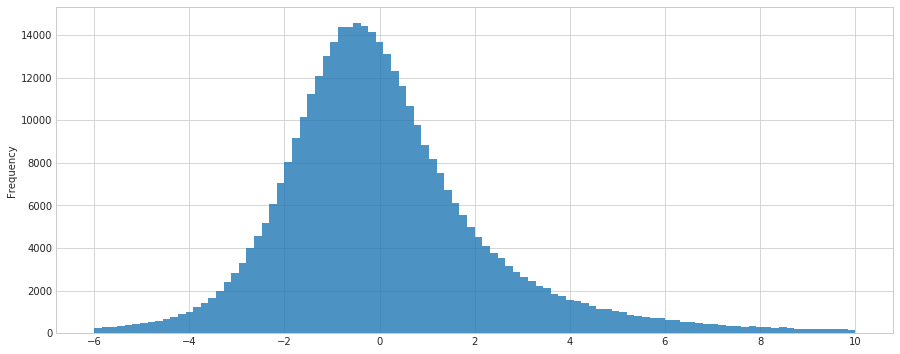

In [48]:
df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
plt.show()

In [49]:
df_val.describe()

,prediction,target,err
count,385253.000000,385253.000000,385253.000000
mean,12.744268,12.984793,0.240526
std,10.333826,11.844161,5.307491
min,-1.466483,-75.000000,-121.896942
25%,7.037635,6.500000,-1.310449
50%,9.163677,9.500000,-0.202710
75%,13.927233,14.500000,1.145766
max,174.919907,999.990000,989.578819


## Make online predictions

In [50]:
import ast

In [51]:
csv_path = os.path.join('s3://', bucket, path_val, 'validate_small_2015.csv')
df = pd.read_csv(csv_path, header=None)

n = 20
features = df.iloc[0:n,1:].values
values  = df.iloc[0:n,0].values

In [53]:
endpoint_name = 'xgboost-2020-06-01-18-27-33-513'
content_type = 'text/csv'
data = "\n".join(["\n".join([",".join(str(x) for x in sample)]) for sample in features])

runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name,\
                                   ContentType='text/csv',\
                                   Body=data) 

In [54]:
result = list(ast.literal_eval(response['Body'].read().decode()))
print(result)

[13.1817560196, 8.07981109619, 14.9320745468, 8.45429420471, 4.96498727798, 6.32571220398, 7.90386867523, 9.35884189606, 7.05845546722, 24.557258606, 5.7872209549, 12.7267751694, 29.5545978546, 9.53172588348, 13.752494812, 6.42121601105, 56.5305747986, 8.91844177246, 16.8305473328, 5.86726474762]
